# Model Selection Notebook

**Objective:** Compare FNN, RNN and Transformer on FPL player‐sequence data, tune key hyperparameters, visualize training, and select the best model for evaluation


### Getting the Data

We use the `make_dataset.py` script to transform processed data into a model-ready format. This includes:

- Dropping the necessary columns
- Creating time sequences
- Handling missing values
- Creating attention masks


What do we need to do:

- Splitting into training/validation/test sets
- Comparing different model architectures
- Visualizing the training and model selection
- Hyperparameter tuning


!!! Our data is both sparse and has outliers, needs to be kept in mind

In [1]:
# for corrent imports
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent  
SRC_DIR       = PROJECT_ROOT / "src"
DATA_DIR      = PROJECT_ROOT / "data"

sys.path.insert(0, str(SRC_DIR))       


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import math
from torch.utils.data import DataLoader

from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from torch.optim.lr_scheduler import SequentialLR, LinearLR, MultiStepLR

from sklearn.preprocessing import StandardScaler, MaxAbsScaler 
import os
import seaborn as sns

from data.make_dataset import prepare_player_sequences, FPLPlayerSequenceDataset

In [3]:
# generate sequences
# work on the time issue
sequences, masks, targets = prepare_player_sequences(
    df_path=str(DATA_DIR / "processed_data.csv"),
    target_col="total_points",
    max_gws_in_sequence= 38,
)



--- Starting Data Preparation for Sequences from C:\Users\asus\OneDrive\Desktop\projects\AI_project\data\processed_data.csv ---
Successfully loaded data. Shape: (28742, 133)

--- Cleaning Data and Selecting Numeric Features ---
Column 'name' is of type object and couldn't be converted to numeric. Marked for dropping.
Column 'position' is of type object and couldn't be converted to numeric. Marked for dropping.
Column 'team' is of type object and couldn't be converted to numeric. Marked for dropping.
Column 'kickoff_time' is of type object and couldn't be converted to numeric. Marked for dropping.
Column '['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'minutes', 'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards', 'saves', 'starts', 'threat', 'yellow_cards', 'xP', 'expected_assists', 'expected_goal_involvements', 'expected_goals', 'expected_goals_conceded', 'value', 'selected', 'transfers_balance', 'trans

In [4]:
scaler = StandardScaler() #better for sparse data 
print("Fitting StandardScaler on training data features...")

def scale_3d_sequences(sequence_array_3d, fitted_scaler):
    if sequence_array_3d.shape[0] == 0: # Handle empty array
        return sequence_array_3d 
    
    original_shape = sequence_array_3d.shape
    num_features_in_array = original_shape[2]
    
    # Reshape to 2D: [N_samples_in_split * S_seq_len, F_features]
    reshaped_array = sequence_array_3d.reshape(-1, num_features_in_array)
    
    # Transform using the FITTED scaler
    scaled_reshaped_array = fitted_scaler.transform(reshaped_array)
    
    # Reshape back to original 3D shape
    return scaled_reshaped_array.reshape(original_shape)

def dataloader_create(sequences, masks, targets, batch_size = 128):

    # train/val/test split
    # we do it a chronological way 
    n = sequences.shape[0]

    train_end = int(n * 0.70)          
    val_end   = train_end + int(n * 0.15)  

    train_idx = np.arange(0, train_end)
    val_idx   = np.arange(train_end, val_end)
    test_idx  = np.arange(val_end, n)

    train_sequences_reshaped = sequences[train_idx].reshape(-1, sequences.shape[2])

    scaler.fit(train_sequences_reshaped)


    sequences_train_scaled = scale_3d_sequences(sequences[train_idx], scaler)
    sequences_val_scaled = scale_3d_sequences(sequences[val_idx], scaler)
    sequences_test_scaled = scale_3d_sequences(sequences[test_idx], scaler)

    masks_train = masks[train_idx]
    targets_train = targets[train_idx]

    masks_val = masks[val_idx]
    targets_val = targets[val_idx]

    masks_test = masks[test_idx]
    targets_test = targets[test_idx]



    train_ds = FPLPlayerSequenceDataset(sequences_train_scaled, targets_train, masks_train) 
    val_ds = FPLPlayerSequenceDataset(sequences_val_scaled, targets_val, masks_val)     
    test_ds = FPLPlayerSequenceDataset(sequences_test_scaled, targets_test, masks_test)     




    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True) 
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


    print(f"Train/Val/Test sizes: {len(train_ds)}/{len(val_ds)}/{len(test_ds)}")

    return train_loader, val_loader, test_loader

Fitting StandardScaler on training data features...


In [5]:
train_loader, val_loader, test_loader = dataloader_create(sequences, masks, targets)


sample_seq, sample_mask, sample_target = next(iter(train_loader))
print(f"Sample batch - Sequences shape: {sample_seq.shape}")      # (batch_size, gameweeks, num_features)
print(f"Sample batch - Attention Mask shape: {sample_mask.shape}") # (batch_size, gameweeks)
print(f"Sample batch - Targets shape: {sample_target.shape}")       # (batch_size, 1)         


Train/Val/Test sizes: 20119/4311/4312
Sample batch - Sequences shape: torch.Size([128, 38, 104])
Sample batch - Attention Mask shape: torch.Size([128, 38])
Sample batch - Targets shape: torch.Size([128, 1])


## Model Architectures Under Consideration

We define two architectures:
- **RNN**: LSTM-based sequence model  
- **Transformer**: self-attention encoder  

We can also use an FNN however we work with time series data it is better to use models supporthing it

**Loss Function:** We aim to predict FPL points, a continuous numerical value, making this a regression task. As points are generally int it can also be formulated as classification but we will go with regression. Common loss functions include Mean Squared Error (`nn.MSELoss()`), which heavily penalizes large errors, or Mean Absolute Error (`nn.SmoothL1Loss()`), which is less sensitive to outliers. Since we have a lot of 0s in target while have significant outliers that are highly impactful we will start with `nn.SmoothL1Loss()`.

### RNN

In [6]:
class RNN(pl.LightningModule):
    def __init__(self, n_features, hidden_dim=128, n_layers=2, dropout=0.4, lr=1e-4, weight_decay = 1e-5, underprediction_penalty= None):
        super().__init__()
        self.save_hyperparameters()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.fc = nn.Linear(hidden_dim, 1)

        
        self.criterion = nn.SmoothL1Loss(beta=1.0)

        self.lr = lr
        self.weight_decay = weight_decay

    def forward(self, x, mask):
        out, _ = self.lstm(x)
        lengths = mask.sum(dim=1)       
        idx = lengths - 1                
      
        
        last = out[torch.arange(out.size(0)), idx]
        return self.fc(last)
    

    def training_step(self, batch, batch_idx):
        x, mask, y = batch
        preds = self(x, mask)

        loss = self.criterion(preds, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, mask, y = batch
        preds = self(x, mask)

        #for validation step we want to be accurate to original points which are integers so we round the prediction

        preds_rounded = torch.round(preds) 


        loss = self.criterion(preds_rounded, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        # Accuracy within a tolerance (e.g., prediction is within +/- 1 point of true)
        tolerance = 1.0
        accuracy_tolerant = (torch.abs(preds_rounded - y) <= tolerance).float().mean()
        self.log("val_accuracy_tolerant_1pt", accuracy_tolerant, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        

        return loss

    def test_step(self, batch, batch_idx):
        x, mask, y = batch
        preds = self(x, mask)

        preds_rounded = torch.round(preds) 


        loss = self.criterion(preds_rounded, y)
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        accuracy_exact = (preds_rounded == y).float().mean()
        self.log("test_accuracy_exact", accuracy_exact, prog_bar=False, on_step=False, on_epoch=True)

        
        # Accuracy within a tolerance (e.g., prediction is within +/- 1 point of true)
        tolerance = 1.0
        accuracy_tolerant = (torch.abs(preds_rounded - y) <= tolerance).float().mean()
        self.log("test_accuracy_tolerant_1pt", accuracy_tolerant, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode="min",      # Reduce LR when the monitored quantity has stopped decreasing
                factor=0.1,      # Factor by which the learning rate will be reduced (new_lr = lr * factor)
                patience=3,      # Number of epochs with no improvement after which LR will be reduced
                verbose=True,    # Print a message when LR is reduced
                min_lr=1e-7      # Lower bound on the learning rate
            )
            
        return {
                "optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "monitor": "val_loss", # Metric to monitor for LR reduction
                    "interval": "epoch",   # Check scheduler at the end of each epoch
                    "frequency": 1         # Check every 1 epoch
                }
            }

    


### Transformer

As transformers can't understand the order of the sequences we add a positional encoding to teach the order of gameweeks

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout = 0.2, sequence_length = 38): 
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(sequence_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(sequence_length, 1, d_model)
        
        
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe.squeeze(1)
        return self.dropout(x)

Then we use encoder only transformer model with a linear classification head

Weighted MSE/MAE (More Advanced): If you particularly care about predicting higher scores better, you could try to implement a custom loss function that gives higher weight to errors on samples where y_true is large. This is more complex to implement and tune.


Transform the Target Variable (and Inverse Transform Predictions):
Log Transformation: log(1 + y). This compresses the scale of large y values, making the distribution less skewed. The model then predicts log(1 + y_pred_transformed). You'd need to inverse transform the predictions before calculating MAE/MSE against the original y for interpretation: exp(y_pred_transformed) - 1.


In [8]:
class Transformer(pl.LightningModule):
    def __init__(self,
                 input_features_dim,
                 d_model = 256,
                 nhead = 4,
                 num_encoder_layers = 2,
                 dim_feedforward = 512,
                 dropout = 0.4,
                 sequence_length = 38,
                 lr = 5e-5,
                 weight_decay = 5e-4,
                 warmup_epochs = 5, #useful for transformers
                 milestones_after_warmup = [3,7],
                 multistep_gamma = 0.2,
                 underprediction_penalty= None
                 ):
        
        super().__init__()
        self.save_hyperparameters()


        # input projection layer necessary for positional encoding 
        self.input_projection = nn.Linear(input_features_dim, d_model)
        nn.init.xavier_uniform_(self.input_projection.weight, gain=0.1)
        nn.init.zeros_(self.input_projection.bias)

        self.input_norm = nn.LayerNorm(d_model) #this solved it

        self.pos_encoder = PositionalEncoding(d_model, dropout, sequence_length=sequence_length)


        # encoder layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True 
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)


        # prediction head that predicts a single value (total_points)
        self.output_head = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1) 
        )

        self.criterion = nn.SmoothL1Loss(beta=1.0)

        self.lr = lr
        self.weight_decay = weight_decay
        self.warmup_epochs = warmup_epochs
        self.milestones_after_warmup = milestones_after_warmup
        self.multistep_gamma = multistep_gamma




    def forward(self, x, mask):
        x = self.input_projection(x) # [batch_size, seq_len, d_model] 
        x = self.input_norm(x)  
        x = nn.ReLU()(x) # Apply activation

        # Add positional encoding
        x = self.pos_encoder(x)
        

        # Pass through Transformer Encoder
        transformer_padding_mask = ~mask # Invert: True for padded, False for valid
        encoded_sequence = self.transformer_encoder(x, src_key_padding_mask=transformer_padding_mask) 

                
        # can't feed a 3d tensor into a linear so 
        batch_size = encoded_sequence.size(0)
        sequence_lengths = mask.sum(dim=1) 
        idx = sequence_lengths-1 # index of last valid gameweek

        # turn into 2D and use the final week that captures the context of previous weeks to decide the total points
        final_representation = encoded_sequence[torch.arange(batch_size), idx, :] 
        
        prediction = self.output_head(final_representation) # [batch_size, 1]
        return prediction


    def training_step(self, batch, batch_idx):
        x, mask, y = batch
        preds = self(x, mask)

        loss = self.criterion(preds, y)
        
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, mask, y = batch
        preds = self(x, mask)

        preds_rounded = torch.round(preds) 


        loss = self.criterion(preds_rounded, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        # Accuracy within a tolerance (e.g., prediction is within +/- 1 point of true)
        tolerance = 1.0
        accuracy_tolerant = (torch.abs(preds_rounded - y) <= tolerance).float().mean()
        self.log("val_accuracy_tolerant_1pt", accuracy_tolerant, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        return loss


    def test_step(self, batch, batch_idx):
        x, mask, y = batch
        preds = self(x, mask)

        preds_rounded = torch.round(preds) 


        loss = self.criterion(preds_rounded, y)
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        accuracy_exact = (preds_rounded == y).float().mean()
        self.log("test_accuracy_exact", accuracy_exact, prog_bar=False, on_step=False, on_epoch=True)

        # Accuracy within a tolerance (e.g., prediction is within +/- 1 point of true)
        tolerance = 1.0
        accuracy_tolerant = (torch.abs(preds_rounded - y) <= tolerance).float().mean()
        self.log("test_accuracy_tolerant_1pt", accuracy_tolerant, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        return loss




    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)



        # warm up for the transformer
        scheduler1 = LinearLR(optimizer, 
                              start_factor=0.01, 
                              end_factor=1.0, 
                              total_iters=self.warmup_epochs) 

      
            
    
        scheduler2 = MultiStepLR(optimizer,
                             milestones=self.milestones_after_warmup,
                             gamma=self.multistep_gamma) # Factor to reduce LR by (e.g., 0.1 or 0.2)




        final_scheduler = SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[self.warmup_epochs])


        

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": final_scheduler,
                "interval": "epoch",  
                "frequency": 1

            }
        }


    

## Training

Implementation of active players will be explained in later cells

In [10]:
# Number of features and sequence length
n_feats = sequences.shape[-1]
seq_len = 38



# Instantiate each LightningModule
models = {
    "RNN": RNN(
        n_features=n_feats,
    ),
    
    "Transformer": Transformer(
        input_features_dim=n_feats,
    ),
}

active_sequences, active_masks, active_targets = prepare_player_sequences(
    df_path=str(DATA_DIR / "active_players.csv"),
    target_col="total_points",
    max_gws_in_sequence= 38,
)

active_sequences_reshaped = active_sequences.reshape(-1, sequences.shape[2])
scaler.fit(active_sequences_reshaped) #normally we would use the scaler that we know from training data 
active_seq_scaled = scale_3d_sequences(active_sequences,scaler)


active_ds = FPLPlayerSequenceDataset(active_seq_scaled, active_targets, active_masks) 
active_loader = DataLoader(active_ds, batch_size=64, shuffle=False) 


--- Starting Data Preparation for Sequences from C:\Users\asus\OneDrive\Desktop\projects\AI_project\data\active_players.csv ---
Successfully loaded data. Shape: (808, 133)

--- Cleaning Data and Selecting Numeric Features ---
Column 'name' is of type object and couldn't be converted to numeric. Marked for dropping.
Column 'position' is of type object and couldn't be converted to numeric. Marked for dropping.
Column 'team' is of type object and couldn't be converted to numeric. Marked for dropping.
Column 'kickoff_time' is of type object and couldn't be converted to numeric. Marked for dropping.
Column '['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'minutes', 'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards', 'saves', 'starts', 'threat', 'yellow_cards', 'xP', 'expected_assists', 'expected_goal_involvements', 'expected_goals', 'expected_goals_conceded', 'value', 'selected', 'transfers_balance', 'transfe

In [17]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger #use tensorboard here
from pytorch_lightning.loggers import TensorBoardLogger



logger = TensorBoardLogger("tb_logs", name="fpl_experiment") 



final_val_losses = {}
csv_log_paths = {}


# LearningRateMonitor 
lr_monitor = LearningRateMonitor(logging_interval="epoch") 

# Fit each model
for name, model in models.items():

    early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001, 
    patience=10,     
    verbose=True,
    mode="min"
    )


    logger = CSVLogger(f"logs_{name}", name="fpl_experiment")


    csv_log_paths[name] = logger.log_dir + "/metrics.csv"

    print(f"▶ Training {name}")
    trainer = Trainer(
    max_epochs=15,
    logger=logger,
    gradient_clip_val= 1,
    callbacks=[early_stop_callback, lr_monitor] 
    )
    
    trainer.fit(
        model=model,
        train_dataloaders=train_loader,
        val_dataloaders=val_loader,
    )

    print(f"Available metrics for model {name}: {model.trainer.callback_metrics.keys()}")

    val_loss = float(model.trainer.callback_metrics["val_loss"])
    final_val_losses[name] = val_loss
    print(f"{name} final val_loss = {val_loss:.4f}")



    test_results = trainer.test(
        model=model,
        dataloaders=test_loader,
    )
    print(test_results)

    print(f"{test_results[0]["test_accuracy_exact"]*100}% of predictions was spot on")
    print(f"Approximately {test_results[0]["test_accuracy_tolerant_1pt"]*100}% of predictions lie in a tolerance of 1")


    test_results = trainer.test(
        model=model,
        dataloaders=active_loader,
    )

    





Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\asus\miniconda3\envs\ai_project\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name      | Type         | Params | Mode 
---------------------------------------------------
0 | lstm      | LSTM         | 251 K  | train
1 | fc        | Linear       | 129    | train
2 | criterion | SmoothL1Loss | 0      | train
---------------------------------------------------
252 K     Trainable params
0         Non-trainable params
252 K     Total params
1.008     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in 

▶ Training RNN
                                                                           

c:\Users\asus\miniconda3\envs\ai_project\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\asus\miniconda3\envs\ai_project\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 158/158 [00:03<00:00, 52.19it/s, v_num=36, val_loss=0.569, val_accuracy_tolerant_1pt=0.877, train_loss=0.713]

Metric val_loss improved. New best score: 0.569


Epoch 1: 100%|██████████| 158/158 [00:02<00:00, 55.54it/s, v_num=36, val_loss=0.567, val_accuracy_tolerant_1pt=0.878, train_loss=0.710]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.567


Epoch 2: 100%|██████████| 158/158 [00:02<00:00, 53.61it/s, v_num=36, val_loss=0.566, val_accuracy_tolerant_1pt=0.877, train_loss=0.708]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.566


Epoch 12: 100%|██████████| 158/158 [00:03<00:00, 51.94it/s, v_num=36, val_loss=0.574, val_accuracy_tolerant_1pt=0.872, train_loss=0.686]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.566. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 158/158 [00:03<00:00, 51.54it/s, v_num=36, val_loss=0.574, val_accuracy_tolerant_1pt=0.872, train_loss=0.686]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\asus\miniconda3\envs\ai_project\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Available metrics for model RNN: dict_keys(['lr-AdamW', 'val_loss', 'val_accuracy_tolerant_1pt', 'train_loss'])
RNN final val_loss = 0.5737
Testing DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 82.85it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric         ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_accuracy_exact     │     0.7815399169921875     │
│ test_accuracy_tolerant_1pt │     0.926484227180481      │
│         test_loss          │    0.30835458636283875     │
└────────────────────────────┴────────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[{'test_loss': 0.30835458636283875, 'test_accuracy_exact': 0.7815399169921875, 'test_accuracy_tolerant_1pt': 0.926484227180481}]
78.15399169921875% of predictions was spot on
Approximately 92.6484227180481% of predictions lie in a tolerance of 1
Testing DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 107.33it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric         ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_accuracy_exact     │    0.18069307506084442     │
│ test_accuracy_tolerant_1pt │    0.45049506425857544     │
│         test_loss          │     3.4738552570343018     │
└────────────────────────────┴────────────────────────────┘

▶ Training Transformer


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | input_projection    | Linear             | 26.9 K | train
1 | input_norm          | LayerNorm          | 512    | train
2 | pos_encoder         | PositionalEncoding | 0      | train
3 | transformer_encoder | TransformerEncoder | 1.1 M  | train
4 | output_head         | Sequential         | 33.0 K | train
5 | criterion           | SmoothL1Loss       | 0      | train
-------------------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.458     Total estimated model 

Epoch 0: 100%|██████████| 158/158 [00:06<00:00, 26.32it/s, v_num=36, val_loss=0.780, val_accuracy_tolerant_1pt=0.801, train_loss=1.030]

Metric val_loss improved. New best score: 0.780


Epoch 1: 100%|██████████| 158/158 [00:05<00:00, 26.39it/s, v_num=36, val_loss=0.605, val_accuracy_tolerant_1pt=0.840, train_loss=0.848]

Metric val_loss improved by 0.175 >= min_delta = 0.001. New best score: 0.605


Epoch 2: 100%|██████████| 158/158 [00:06<00:00, 26.32it/s, v_num=36, val_loss=0.594, val_accuracy_tolerant_1pt=0.842, train_loss=0.780]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.594


Epoch 4: 100%|██████████| 158/158 [00:05<00:00, 29.80it/s, v_num=36, val_loss=0.600, val_accuracy_tolerant_1pt=0.833, train_loss=0.763]

c:\Users\asus\miniconda3\envs\ai_project\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 4: 100%|██████████| 158/158 [00:05<00:00, 26.56it/s, v_num=36, val_loss=0.578, val_accuracy_tolerant_1pt=0.854, train_loss=0.751]

Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 0.578


Epoch 6: 100%|██████████| 158/158 [00:05<00:00, 26.47it/s, v_num=36, val_loss=0.572, val_accuracy_tolerant_1pt=0.861, train_loss=0.741]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.572


Epoch 10: 100%|██████████| 158/158 [00:05<00:00, 26.62it/s, v_num=36, val_loss=0.570, val_accuracy_tolerant_1pt=0.863, train_loss=0.731]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.570


Epoch 14: 100%|██████████| 158/158 [00:05<00:00, 26.50it/s, v_num=36, val_loss=0.571, val_accuracy_tolerant_1pt=0.861, train_loss=0.727]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 158/158 [00:06<00:00, 26.24it/s, v_num=36, val_loss=0.571, val_accuracy_tolerant_1pt=0.861, train_loss=0.727]
Available metrics for model Transformer: dict_keys(['lr-AdamW', 'val_loss', 'val_accuracy_tolerant_1pt', 'train_loss'])
Transformer final val_loss = 0.5706


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 55.95it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric         ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_accuracy_exact     │     0.7929035425186157     │
│ test_accuracy_tolerant_1pt │     0.9318181872367859     │
│         test_loss          │     0.2793947160243988     │
└────────────────────────────┴────────────────────────────┘

[{'test_loss': 0.2793947160243988, 'test_accuracy_exact': 0.7929035425186157, 'test_accuracy_tolerant_1pt': 0.9318181872367859}]
79.29035425186157% of predictions was spot on
Approximately 93.18181872367859% of predictions lie in a tolerance of 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 80.98it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric         ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_accuracy_exact     │    0.18069307506084442     │
│ test_accuracy_tolerant_1pt │     0.4443069398403168     │
│         test_loss          │     3.2572710514068604     │
└────────────────────────────┴────────────────────────────┘

We can see that even though RNN and Transformer will be prefered in this project FNN also performed comparatively well which might suggest that time dependency of our data (like forms or general monthly trends) are not as important as we first thought it was

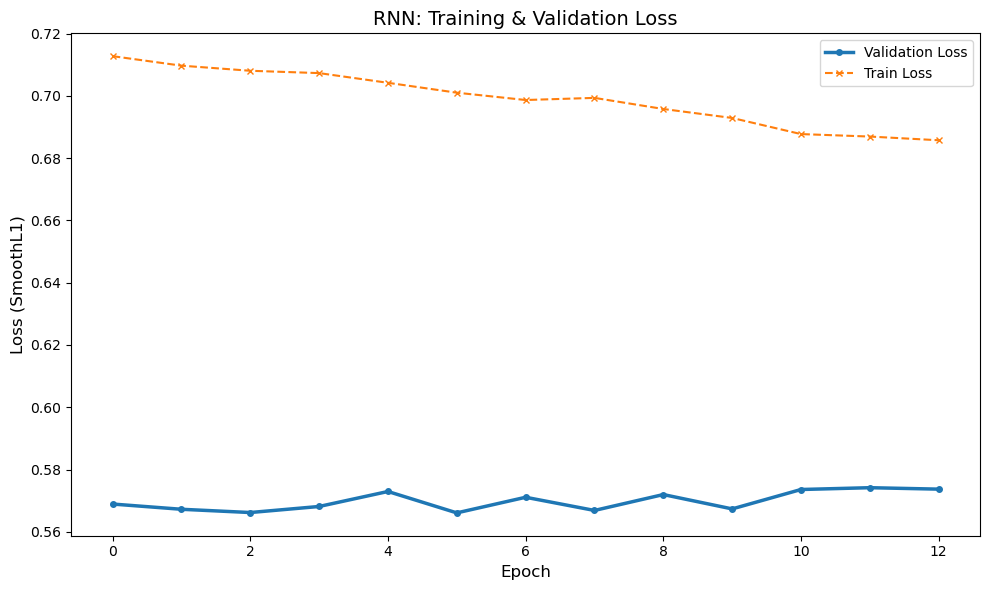

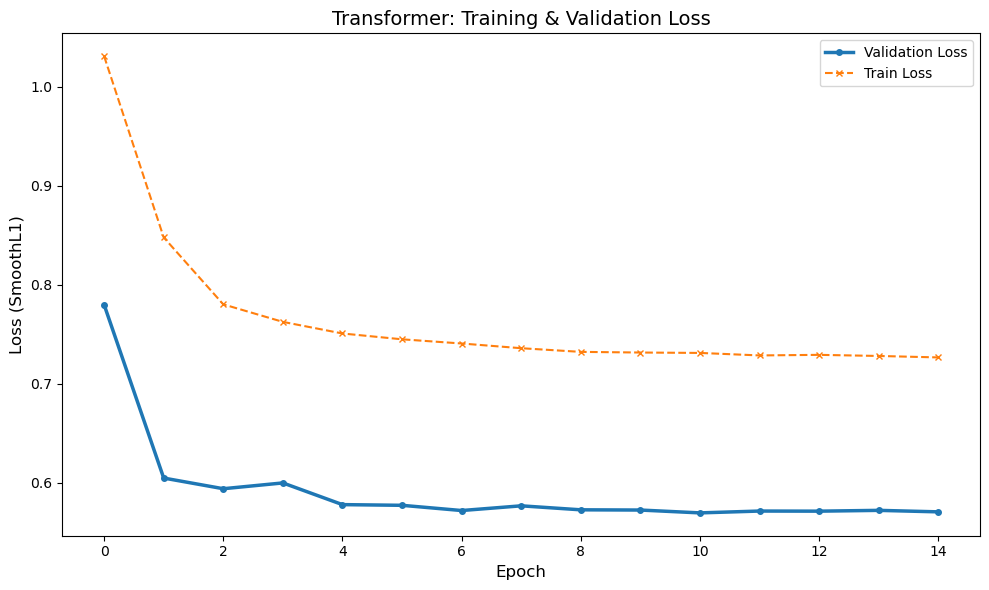

In [18]:
for model_name, log_path in csv_log_paths.items():

    plt.figure(figsize=(10, 6)) 
        
    metrics_df = pd.read_csv(log_path) # Load metrics for the CURRENT model
        

    plot_title = f"{model_name}: Training & Validation Loss"
            

    # Validation Loss

    val_data_current_model = metrics_df.dropna(subset=["epoch", "val_loss"])
    val_data_current_model = val_data_current_model.sort_values(by="epoch")
                
    plt.plot(val_data_current_model["epoch"], val_data_current_model["val_loss"], 
            label=f"Validation Loss", linewidth=2.5, marker="o", markersize=4)



    # Training Loss


    train_data_current_model = metrics_df.dropna(subset=["epoch", "train_loss"])
    train_data_current_model = train_data_current_model.sort_values(by="epoch")
        
    plt.plot(train_data_current_model["epoch"], train_data_current_model["train_loss"], 
            label=f"Train Loss", linestyle="--", marker="x", markersize=4)
                

            
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss (SmoothL1)", fontsize=12)
    plt.title(plot_title, fontsize=14)
    plt.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show() 



## Fundamental Difficulty of FPL Prediction:

FPL is notoriously hard to predict with high accuracy due to inherent randomness, injuries, sudden form changes, tactical shifts, etc. It's possible that with the current set of publicly available features, there's a natural limit to how well any model can perform, and your models are all hitting that limit quickly.

All models might be quickly learning the "easy" part of the prediction (e.g., most players score 0-2 points). However, what about good players?

Here we test our RNN and Transformer (as they both gave similar val error) on Mohammed Salah, one of the best players in the league and one of the most popular picks in a FPL team. The performance of outliers is important because even though they are a small percent of the total players, they are the players that gets selected the most

Predicting 7+ points is almost impossible as there is no way to predict a player doing a hat-trick before the match; therefore, we will not expect the model to predict the peaks but understand general trends of the player to some level


--- Starting Data Preparation for Sequences from C:\Users\asus\OneDrive\Desktop\projects\AI_project\data\salah.csv ---
Successfully loaded data. Shape: (36, 133)

--- Cleaning Data and Selecting Numeric Features ---
Column 'name' is of type object and couldn't be converted to numeric. Marked for dropping.
Column 'position' is of type object and couldn't be converted to numeric. Marked for dropping.
Column 'team' is of type object and couldn't be converted to numeric. Marked for dropping.
Column 'kickoff_time' is of type object and couldn't be converted to numeric. Marked for dropping.
Column '['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'minutes', 'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards', 'saves', 'starts', 'threat', 'yellow_cards', 'xP', 'expected_assists', 'expected_goal_involvements', 'expected_goals', 'expected_goals_conceded', 'value', 'selected', 'transfers_balance', 'transfers_in', 't

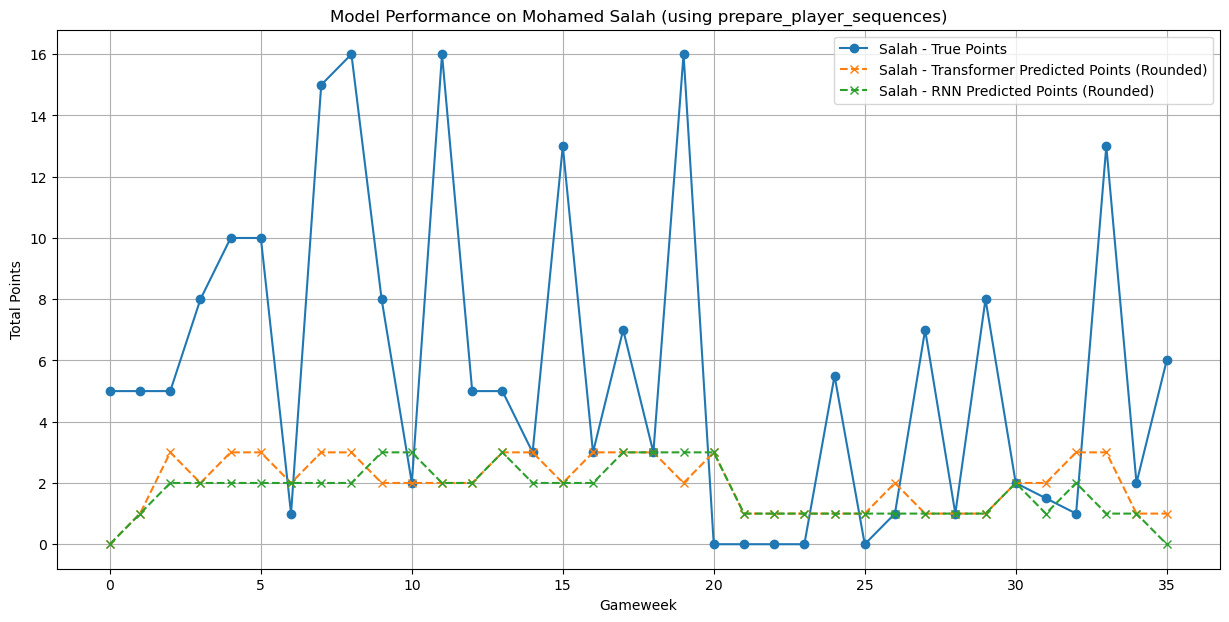

In [19]:
#Mohamed Salah prediction

salah_sequences, salah_masks, salah_targets = prepare_player_sequences(
    df_path=str(DATA_DIR / "salah.csv"),
    target_col="total_points",
    max_gws_in_sequence= 38,
)

salah_sequences_scaled = scale_3d_sequences(salah_sequences, scaler)

salah_sequences_tensor = torch.tensor(salah_sequences_scaled, dtype=torch.float32)
salah_masks_tensor = torch.tensor(salah_masks, dtype=torch.bool)



salah_predictions_transformer = []
salah_predictions_rnn = []
salah_predictions_fnn = []

with torch.no_grad():
    for i in range(salah_sequences_scaled.shape[0]):
        seq_input = salah_sequences_tensor[i].unsqueeze(0)
        mask_input = salah_masks_tensor[i].unsqueeze(0)
        pred_transformer = models["Transformer"](seq_input, mask_input) 
        pred_rnn = models["RNN"](seq_input, mask_input) 

        

        salah_predictions_transformer.append(pred_transformer.item())
        salah_predictions_rnn.append(pred_rnn.item())

salah_predictions_transformer_rounded = np.round(salah_predictions_transformer)
salah_predictions_rnn_rounded = np.round(salah_predictions_rnn)


plt.figure(figsize=(15, 7))
plt.plot(salah_targets, label='Salah - True Points', marker='o')
plt.plot(salah_predictions_transformer_rounded, label='Salah - Transformer Predicted Points (Rounded)', marker='x', linestyle='--')
plt.plot(salah_predictions_rnn_rounded, label='Salah - RNN Predicted Points (Rounded)', marker='x', linestyle='--')
plt.xlabel("Gameweek")
plt.ylabel("Total Points")
plt.title(f"Model Performance on Mohamed Salah (using prepare_player_sequences)")
plt.legend()
plt.grid(True)
plt.show()

### How to solve the problem of undershooting

Even though most of the players get 0-1 points, these players do not generally get selected at all and most of the time only the outlier players that scores high gets selected. Therefore being able to predict important players is more important than overall test score.

- Filtering for active players. Filtering our data on average points will give us players thar are active which is useful to know for FPL

- A custom weighted loss function. We can implement a loss function where it penalizes undershooting more than overshooting

- Log transform of target. We can use the log of total points to compress the scale of scores and make distrubition less skewed. Then we have to do a reverse transformation for evaluation


We clearly see that general accuracy is lower for these types of players so we try to come up with a model that will give us better results for active players

### Finalization of Model Architecture 

As it looks like right now, our model's tendency of not predicting higher number doesn't change that much with the dismissal of inactive players 

Therefore our main focus will be on hyperparameter tuning to get the best we can from the models 

Before the hyperparameter selection we define the model architecture that we will use. We will test a specialized loss fonction and going to use a log transformation of target values and implement it in the final model if the results are satisfactory. These architectures will be the ones that will be used in our train.py file

In [20]:
# custom weighted loss function

class WeightedSmoothL1Loss(nn.Module):
    def __init__(self, beta=1.0, underprediction_penalty=2.0):
        super().__init__()
        self.beta = beta
        self.underprediction_penalty = underprediction_penalty
        self.smooth_l1_loss = nn.SmoothL1Loss(reduction='none', beta=beta)

    def forward(self, input_preds, target_actuals):
        loss = self.smooth_l1_loss(input_preds, target_actuals)

        penalty_weights = torch.ones_like(loss)
        penalty_weights[input_preds < target_actuals] = self.underprediction_penalty

        weighted_loss = loss * penalty_weights
        return weighted_loss.mean() 
    

# using log transforms 

sequences, masks, targets = prepare_player_sequences(
    df_path=str(DATA_DIR / "processed_data.csv"),
    target_col="log1p_total_points",
    max_gws_in_sequence= 38,
)

train_loader_log, val_loader_log, test_loader_log = dataloader_create(sequences, masks, targets)

--- Starting Data Preparation for Sequences from C:\Users\asus\OneDrive\Desktop\projects\AI_project\data\processed_data.csv ---
Successfully loaded data. Shape: (28742, 133)

--- Cleaning Data and Selecting Numeric Features ---
Column 'name' is of type object and couldn't be converted to numeric. Marked for dropping.
Column 'position' is of type object and couldn't be converted to numeric. Marked for dropping.
Column 'team' is of type object and couldn't be converted to numeric. Marked for dropping.
Column 'kickoff_time' is of type object and couldn't be converted to numeric. Marked for dropping.
Column '['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'minutes', 'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards', 'saves', 'starts', 'threat', 'yellow_cards', 'xP', 'expected_assists', 'expected_goal_involvements', 'expected_goals', 'expected_goals_conceded', 'value', 'selected', 'transfers_balance', 'trans

Defining the model and evaluation parameters for log-transform

In [ ]:
class FinalRNN(RNN): # Inherits from RNN
    def __init__(self, n_features, hidden_dim=64, n_layers=3, dropout=0.4, lr=1e-4, weight_decay=1e-5,underprediction_penalty=1.0):
        super().__init__(n_features)


        self.underprediction_penalty = underprediction_penalty
        self.criterion = WeightedSmoothL1Loss(underprediction_penalty=self.underprediction_penalty) #when 1.0 same as SmoothL1

    def validation_step(self, batch, batch_idx):
        x, mask, y_log = batch # y_log is log(1+y_true)
        preds_log = self(x, mask) # Model predicts log(1+y_pred)

        loss = self.criterion(preds_log, y_log) # Loss is on log-transformed values
        self.log("val_loss_log_transformed", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        # Inverse transform for interpretable metrics
        preds_orig_scale = torch.expm1(preds_log) # expm1 is exp(x) - 1
        y_orig_scale = torch.expm1(y_log)
        preds_rounded = torch.round(preds_orig_scale)

        real_loss = WeightedSmoothL1Loss()(preds_rounded, y_orig_scale) 
        self.log("val_loss", real_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        tolerance = 1.0
        accuracy_tolerant = (torch.abs(preds_rounded - y_orig_scale) <= tolerance).float().mean()
        self.log("val_accuracy_tolerant_1pt", accuracy_tolerant, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss 

    def test_step(self, batch, batch_idx):
        x, mask, y_log = batch
        preds_log = self(x, mask)
        loss = self.criterion(preds_log, y_log)
        self.log("test_loss_log_transformed", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        preds_orig_scale = torch.expm1(preds_log)
        y_orig_scale = torch.expm1(y_log)
        preds_rounded = torch.round(preds_orig_scale)

        real_loss = WeightedSmoothL1Loss()(preds_rounded, y_orig_scale)
        self.log("test_loss", real_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        accuracy_exact = (preds_rounded == y_orig_scale).float().mean()
        self.log("test_accuracy_exact", accuracy_exact, prog_bar=False, on_step=False, on_epoch=True)

        tolerance = 1.0
        accuracy_tolerant = (torch.abs(preds_rounded - y_orig_scale) <= tolerance).float().mean()
        self.log("test_accuracy_tolerant_1pt", accuracy_tolerant, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss




class FinalTransformer(Transformer): # Inherits from your existing Transformer class
    def __init__(self, input_features_dim, d_model=512, nhead=4, num_encoder_layers=3,
                 dim_feedforward=512, dropout=0.4, sequence_length=38, lr=5e-5,
                 weight_decay=5e-4, warmup_epochs=5, milestones_after_warmup=[3,7],
                 multistep_gamma=0.2, underprediction_penalty=1.0):
        super().__init__(input_features_dim)

        self.underprediction_penalty = underprediction_penalty
        self.criterion = WeightedSmoothL1Loss(underprediction_penalty=self.underprediction_penalty) 

    def validation_step(self, batch, batch_idx):
        x, mask, y_log = batch
        preds_log = self(x, mask)
        loss = self.criterion(preds_log, y_log)
        self.log("val_loss_log_transformed", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        preds_orig_scale = torch.expm1(preds_log)
        y_orig_scale = torch.expm1(y_log)
        preds_rounded = torch.round(preds_orig_scale)

        real_loss = WeightedSmoothL1Loss(beta=0.1)(preds_rounded, y_orig_scale)
        self.log("val_loss", real_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        tolerance = 1.0
        accuracy_tolerant = (torch.abs(preds_rounded - y_orig_scale) <= tolerance).float().mean()
        self.log("val_accuracy_tolerant_1pt", accuracy_tolerant, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, mask, y_log = batch
        preds_log = self(x, mask)
        loss = self.criterion(preds_log, y_log)
        self.log("test_loss_log_transformed", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        preds_orig_scale = torch.expm1(preds_log)
        y_orig_scale = torch.expm1(y_log)
        preds_rounded = torch.round(preds_orig_scale)

        mae_orig_scale = WeightedSmoothL1Loss(beta=0.1)(preds_rounded, y_orig_scale)
        self.log("test_loss", mae_orig_scale, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        accuracy_exact = (preds_rounded == y_orig_scale).float().mean()
        self.log("test_accuracy_exact", accuracy_exact, prog_bar=False, on_step=False, on_epoch=True)

        tolerance = 1.0
        accuracy_tolerant = (torch.abs(preds_rounded - y_orig_scale) <= tolerance).float().mean()
        self.log("test_accuracy_tolerant_1pt", accuracy_tolerant, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss


Training

In [22]:
n_feats = sequences.shape[-1]
seq_len = 38


models_to_evaluate_advanced = {
    "FinalRNN": FinalRNN(
        n_features=n_feats,
    ),

    "FinalTransformer": FinalTransformer(
        input_features_dim=n_feats,
    ),
}

In [23]:
final_advanced_results  = {}
csv_log_paths_advanced  = {}


active_sequences, active_masks, active_targets = prepare_player_sequences(
    df_path=str(DATA_DIR / "active_players.csv"),
    target_col="log1p_total_points",
    max_gws_in_sequence= 38,
)


active_sequences_reshaped = active_sequences.reshape(-1, sequences.shape[2])
scaler.fit(active_sequences_reshaped) #normally we would use the scaler that we know from training data 
active_seq_scaled = scale_3d_sequences(active_sequences,scaler)


active_ds = FPLPlayerSequenceDataset(active_seq_scaled, active_targets, active_masks) 
active_loader_log = DataLoader(active_ds, batch_size=128, shuffle=False) 



# LearningRateMonitor 
lr_monitor = LearningRateMonitor(logging_interval="epoch") 

# Fit each model
for name, model in models_to_evaluate_advanced.items():

    early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0005, # Slightly smaller delta, as losses are already low
    patience=7,      # Increase patience a bit to allow scheduler to work
    verbose=True,
    mode="min"
    )

    final_logger = CSVLogger(f"logs_{name}", name="fpl_experiment")


    csv_log_paths_advanced[name] = logger.log_dir + "/metrics.csv"

    print(f"▶ Training {name}")
    trainer = Trainer(
    max_epochs=25,
    logger=final_logger,
    gradient_clip_val= 1,
    callbacks=[early_stop_callback, lr_monitor] 
    )
    
    trainer.fit(
        model=model,
        train_dataloaders=train_loader_log,
        val_dataloaders=val_loader_log,
    )

    print(f"Available metrics for model {name}: {model.trainer.callback_metrics.keys()}")

    val_loss = float(model.trainer.callback_metrics["val_loss"])
    final_advanced_results[name] = val_loss
    print(f"{name} final val_loss = {val_loss:.4f}")




    test_results = trainer.test(
        model=model,
        dataloaders=test_loader_log,
    )
    print(test_results)


    print("Testing active players")

    test_results = trainer.test(
        model=model,
        dataloaders=active_loader_log,
    )
    print(test_results)

    






--- Starting Data Preparation for Sequences from C:\Users\asus\OneDrive\Desktop\projects\AI_project\data\active_players.csv ---
Successfully loaded data. Shape: (808, 133)

--- Cleaning Data and Selecting Numeric Features ---
Column 'name' is of type object and couldn't be converted to numeric. Marked for dropping.
Column 'position' is of type object and couldn't be converted to numeric. Marked for dropping.
Column 'team' is of type object and couldn't be converted to numeric. Marked for dropping.
Column 'kickoff_time' is of type object and couldn't be converted to numeric. Marked for dropping.
Column '['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'minutes', 'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards', 'saves', 'starts', 'threat', 'yellow_cards', 'xP', 'expected_assists', 'expected_goal_involvements', 'expected_goals', 'expected_goals_conceded', 'value', 'selected', 'transfers_balance', 'transfe

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\asus\miniconda3\envs\ai_project\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | lstm      | LSTM                 | 251 K  | train
1 | fc        | Linear               | 129    | train
2 | criterion | WeightedSmoothL1Loss | 0      | train
-----------------------------------------------------------
252 K     Trainable params
0         Non-trainable params
252 K     Total params
1.008     Total estimated model params size (MB)
4    

Successfully created sequences. Shape: (808, 38, 104)
Targets shape: (808,)
Attention masks shape: (808, 38)
▶ Training FinalRNN
                                                                           

c:\Users\asus\miniconda3\envs\ai_project\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\asus\miniconda3\envs\ai_project\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 158/158 [00:03<00:00, 49.12it/s, v_num=18, val_loss_log_transformed=0.123, val_loss=1.100, val_accuracy_tolerant_1pt=0.869, train_loss=0.175]

Metric val_loss improved. New best score: 1.103


Epoch 1: 100%|██████████| 158/158 [00:03<00:00, 50.96it/s, v_num=18, val_loss_log_transformed=0.115, val_loss=1.060, val_accuracy_tolerant_1pt=0.876, train_loss=0.145]

Metric val_loss improved by 0.041 >= min_delta = 0.0005. New best score: 1.061


Epoch 2: 100%|██████████| 158/158 [00:03<00:00, 51.24it/s, v_num=18, val_loss_log_transformed=0.111, val_loss=1.040, val_accuracy_tolerant_1pt=0.875, train_loss=0.138]

Metric val_loss improved by 0.023 >= min_delta = 0.0005. New best score: 1.038


Epoch 5: 100%|██████████| 158/158 [00:02<00:00, 74.85it/s, v_num=18, val_loss_log_transformed=0.108, val_loss=1.030, val_accuracy_tolerant_1pt=0.879, train_loss=0.130]

Metric val_loss improved by 0.007 >= min_delta = 0.0005. New best score: 1.031


Epoch 6: 100%|██████████| 158/158 [00:02<00:00, 77.75it/s, v_num=18, val_loss_log_transformed=0.108, val_loss=1.010, val_accuracy_tolerant_1pt=0.873, train_loss=0.129]

Metric val_loss improved by 0.018 >= min_delta = 0.0005. New best score: 1.013


Epoch 13: 100%|██████████| 158/158 [00:02<00:00, 74.84it/s, v_num=18, val_loss_log_transformed=0.107, val_loss=1.030, val_accuracy_tolerant_1pt=0.877, train_loss=0.123]

Monitored metric val_loss did not improve in the last 7 records. Best score: 1.013. Signaling Trainer to stop.


Epoch 13: 100%|██████████| 158/158 [00:02<00:00, 74.13it/s, v_num=18, val_loss_log_transformed=0.107, val_loss=1.030, val_accuracy_tolerant_1pt=0.877, train_loss=0.123]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Available metrics for model FinalRNN: dict_keys(['lr-AdamW', 'val_loss_log_transformed', 'val_loss', 'val_accuracy_tolerant_1pt', 'train_loss'])
FinalRNN final val_loss = 1.0254


c:\Users\asus\miniconda3\envs\ai_project\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 104.78it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric         ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_accuracy_exact     │     0.7887291312217712     │
│ test_accuracy_tolerant_1pt │     0.9271799921989441     │
│         test_loss          │     0.558992326259613      │
│ test_loss_log_transformed  │    0.08009172230958939     │
└────────────────────────────┴────────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[{'test_loss_log_transformed': 0.08009172230958939, 'test_loss': 0.558992326259613, 'test_accuracy_exact': 0.7887291312217712, 'test_accuracy_tolerant_1pt': 0.9271799921989441}]
Testing active players
Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 101.39it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric         ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_accuracy_exact     │    0.18440593779087067     │
│ test_accuracy_tolerant_1pt │    0.45173266530036926     │
│         test_loss          │     6.732982635498047      │
│ test_loss_log_transformed  │    0.45148032903671265     │
└────────────────────────────┴────────────────────────────┘

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True


[{'test_loss_log_transformed': 0.45148032903671265, 'test_loss': 6.732982635498047, 'test_accuracy_exact': 0.18440593779087067, 'test_accuracy_tolerant_1pt': 0.45173266530036926}]
▶ Training FinalTransformer


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                 | Params | Mode 
---------------------------------------------------------------------
0 | input_projection    | Linear               | 26.9 K | train
1 | input_norm          | LayerNorm            | 512    | train
2 | pos_encoder         | PositionalEncoding   | 0      | train
3 | transformer_encoder | TransformerEncoder   | 1.1 M  | train
4 | output_head         | Sequential           | 33.0 K | train
5 | criterion           | WeightedSmoothL1Loss | 0      | train
---------------------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.458     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 158/158 [00:03<00:00, 40.28it/s, v_num=17, val_loss_log_transformed=0.352, val_loss=1.880, val_accuracy_tolerant_1pt=0.813, train_loss=0.579]

Metric val_loss improved. New best score: 1.881


Epoch 1: 100%|██████████| 158/158 [00:03<00:00, 40.16it/s, v_num=17, val_loss_log_transformed=0.221, val_loss=1.500, val_accuracy_tolerant_1pt=0.697, train_loss=0.311]

Metric val_loss improved by 0.384 >= min_delta = 0.0005. New best score: 1.497


Epoch 2: 100%|██████████| 158/158 [00:03<00:00, 40.36it/s, v_num=17, val_loss_log_transformed=0.197, val_loss=1.370, val_accuracy_tolerant_1pt=0.741, train_loss=0.243]

Metric val_loss improved by 0.127 >= min_delta = 0.0005. New best score: 1.370


Epoch 3: 100%|██████████| 158/158 [00:03<00:00, 39.96it/s, v_num=17, val_loss_log_transformed=0.187, val_loss=1.330, val_accuracy_tolerant_1pt=0.762, train_loss=0.228]

Metric val_loss improved by 0.038 >= min_delta = 0.0005. New best score: 1.331


Epoch 4: 100%|██████████| 158/158 [00:03<00:00, 44.69it/s, v_num=17, val_loss_log_transformed=0.187, val_loss=1.330, val_accuracy_tolerant_1pt=0.762, train_loss=0.228]

c:\Users\asus\miniconda3\envs\ai_project\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 4: 100%|██████████| 158/158 [00:03<00:00, 39.65it/s, v_num=17, val_loss_log_transformed=0.177, val_loss=1.280, val_accuracy_tolerant_1pt=0.800, train_loss=0.222]

Metric val_loss improved by 0.049 >= min_delta = 0.0005. New best score: 1.282


Epoch 6: 100%|██████████| 158/158 [00:04<00:00, 38.87it/s, v_num=17, val_loss_log_transformed=0.171, val_loss=1.270, val_accuracy_tolerant_1pt=0.800, train_loss=0.210]

Metric val_loss improved by 0.014 >= min_delta = 0.0005. New best score: 1.267


Epoch 7: 100%|██████████| 158/158 [00:04<00:00, 38.19it/s, v_num=17, val_loss_log_transformed=0.171, val_loss=1.270, val_accuracy_tolerant_1pt=0.791, train_loss=0.209]

Metric val_loss improved by 0.001 >= min_delta = 0.0005. New best score: 1.267


Epoch 8: 100%|██████████| 158/158 [00:04<00:00, 37.96it/s, v_num=17, val_loss_log_transformed=0.170, val_loss=1.270, val_accuracy_tolerant_1pt=0.799, train_loss=0.205]

Metric val_loss improved by 0.001 >= min_delta = 0.0005. New best score: 1.266


Epoch 9: 100%|██████████| 158/158 [00:04<00:00, 37.55it/s, v_num=17, val_loss_log_transformed=0.169, val_loss=1.250, val_accuracy_tolerant_1pt=0.807, train_loss=0.206]

Metric val_loss improved by 0.014 >= min_delta = 0.0005. New best score: 1.252


Epoch 16: 100%|██████████| 158/158 [00:04<00:00, 35.94it/s, v_num=17, val_loss_log_transformed=0.171, val_loss=1.270, val_accuracy_tolerant_1pt=0.792, train_loss=0.201]

Monitored metric val_loss did not improve in the last 7 records. Best score: 1.252. Signaling Trainer to stop.


Epoch 16: 100%|██████████| 158/158 [00:04<00:00, 35.54it/s, v_num=17, val_loss_log_transformed=0.171, val_loss=1.270, val_accuracy_tolerant_1pt=0.792, train_loss=0.201]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Available metrics for model FinalTransformer: dict_keys(['lr-AdamW', 'val_loss_log_transformed', 'val_loss', 'val_accuracy_tolerant_1pt', 'train_loss'])
FinalTransformer final val_loss = 1.2705
Testing DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 74.30it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric         ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_accuracy_exact     │     0.7407235503196716     │
│ test_accuracy_tolerant_1pt │     0.905148446559906      │
│         test_loss          │     0.6771220564842224     │
│ test_loss_log_transformed  │    0.11133868247270584     │
└────────────────────────────┴────────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[{'test_loss_log_transformed': 0.11133868247270584, 'test_loss': 0.6771220564842224, 'test_accuracy_exact': 0.7407235503196716, 'test_accuracy_tolerant_1pt': 0.905148446559906}]
Testing active players
Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 64.69it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric         ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_accuracy_exact     │    0.12747524678707123     │
│ test_accuracy_tolerant_1pt │     0.3502475321292877     │
│         test_loss          │     6.202970504760742      │
│ test_loss_log_transformed  │     0.5866237282752991     │
└────────────────────────────┴────────────────────────────┘

[{'test_loss_log_transformed': 0.5866237282752991, 'test_loss': 6.202970504760742, 'test_accuracy_exact': 0.12747524678707123, 'test_accuracy_tolerant_1pt': 0.3502475321292877}]


--- Starting Data Preparation for Sequences from C:\Users\asus\OneDrive\Desktop\projects\AI_project\data\salah.csv ---
Successfully loaded data. Shape: (36, 133)

--- Cleaning Data and Selecting Numeric Features ---
Column 'name' is of type object and couldn't be converted to numeric. Marked for dropping.
Column 'position' is of type object and couldn't be converted to numeric. Marked for dropping.
Column 'team' is of type object and couldn't be converted to numeric. Marked for dropping.
Column 'kickoff_time' is of type object and couldn't be converted to numeric. Marked for dropping.
Column '['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'minutes', 'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards', 'saves', 'starts', 'threat', 'yellow_cards', 'xP', 'expected_assists', 'expected_goal_involvements', 'expected_goals', 'expected_goals_conceded', 'value', 'selected', 'transfers_balance', 'transfers_in', 't

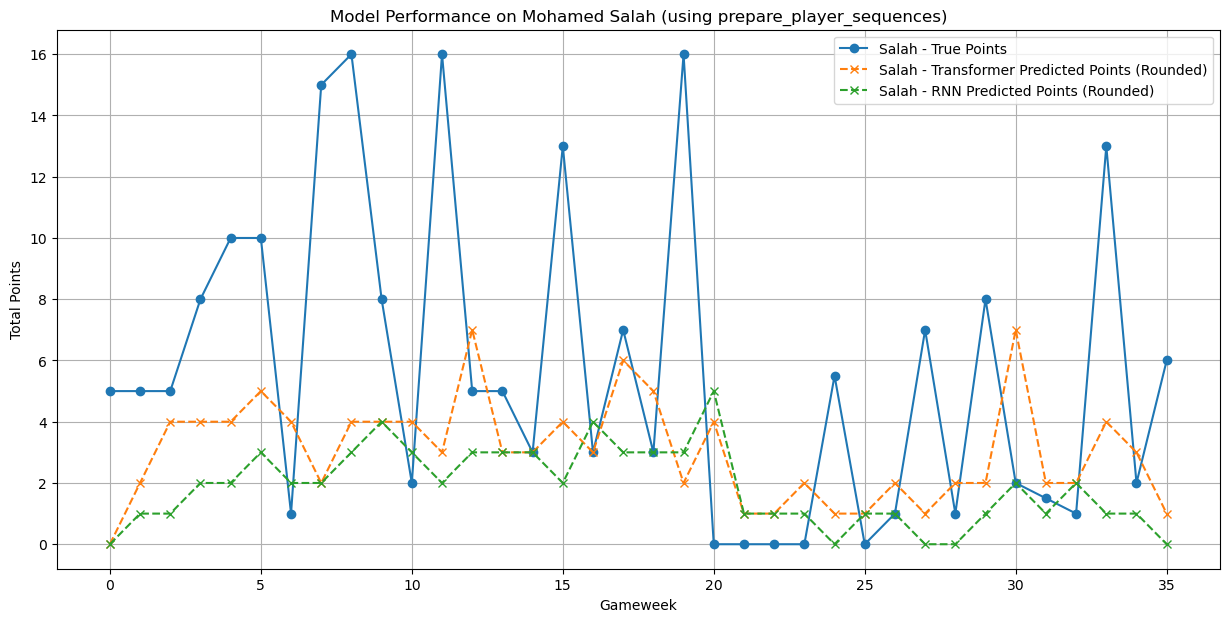

In [24]:
salah_sequences, salah_masks, salah_targets = prepare_player_sequences(
    df_path=str(DATA_DIR / "salah.csv"),
    target_col="log1p_total_points",
    max_gws_in_sequence= 38,
)

salah_sequences_scaled = scale_3d_sequences(salah_sequences, scaler)

salah_sequences_tensor = torch.tensor(salah_sequences_scaled, dtype=torch.float32)
salah_masks_tensor = torch.tensor(salah_masks, dtype=torch.bool)

salah_predictions_transformer = []
salah_predictions_rnn = []

with torch.no_grad():
    for i in range(salah_sequences_scaled.shape[0]):
        seq_input = salah_sequences_tensor[i].unsqueeze(0)
        mask_input = salah_masks_tensor[i].unsqueeze(0)
        pred_transformer = models_to_evaluate_advanced["FinalTransformer"](seq_input, mask_input) 
        pred_rnn = models_to_evaluate_advanced["FinalRNN"](seq_input, mask_input) 


        salah_predictions_transformer.append(np.expm1(pred_transformer.item()))
        salah_predictions_rnn.append(np.expm1(pred_rnn.item()))

salah_predictions_transformer_rounded = np.round(salah_predictions_transformer)
salah_predictions_rnn_rounded = np.round(salah_predictions_rnn)



plt.figure(figsize=(15, 7))
plt.plot(np.expm1(salah_targets), label='Salah - True Points', marker='o')
plt.plot(salah_predictions_transformer_rounded, label='Salah - Transformer Predicted Points (Rounded)', marker='x', linestyle='--')
plt.plot(salah_predictions_rnn_rounded, label='Salah - RNN Predicted Points (Rounded)', marker='x', linestyle='--')
plt.xlabel("Gameweek")
plt.ylabel("Total Points")
plt.title(f"Model Performance on Mohamed Salah (using prepare_player_sequences)")
plt.legend()
plt.grid(True)
plt.show()

As we can see from the test evaluations, the new models perform similarly to our previous versions in general test data. However for evaluation in active players there is a conundrum. If we look at it statistically our new model performs less accuracy in its predictions. However If we analyze it from the difference between Salah's predictions we see new version fits way better. 

Therefore we can look behind the numerical problem. Problem may lie in the fact that a model might predict a good match reasonibly (maybe his form was good), there is a possbility of player extremely underperforming or getting injured the day before. Therefore the prediction of a high score will increase the loss even though it was the reasonable thing to do. Our previous model was outputting low prediction even if the players are expected to perform highly in an effort to keep the error loss in case of an unlucky performance. Therefore; these two types of models have benefits of their own while the newer version might be prefered for an outstanding player like Salah

# Main Model Selection

Here we run our main hyperparameter selection to select our best parameters which is crucial especially for transformers. This is going to be the most computitionally expensive slide; therefore, to reduce the overall runtime by not running this cell, selected parameters and the model that is selected can be found in models.py

Even though our previous architectures achieved better errors compared to log-transform models, we wil focus on our the final version of the models because they exhibit better predictions for high performing players as our "salah evaluation" shows. Also with high prediction rates our old models are already pretty optimized while our new model will benefit more from hyperparameter selection. For even more robustness we can think of using a mixture of models to optimize our prediction

In [25]:
%%capture       
import random 
# for a cleaner notebook
# normally more combinations were tried but for the sake of run-time here we only do a few

transformer_param_dist = {
    'lr': [1e-5, 5e-5, 1e-4], 
    'd_model': [256, 512], 
    'nhead': [2, 4, 8], 
    'num_encoder_layers': [2, 4, 6],
    'dim_feedforward': [512, 1024],
    'dropout': [0.4, 0.5, 0.6],
    'weight_decay': [1e-5, 5e-5, 1e-4],
    'warmup_epochs': [3, 5, 7],
    'milestone_pattern': [[3, 7]], #no search here
    'multistep_gamma': [0.1, 0.2],
    'underprediction_penalty': [1.0, 1.5, 2.0]
}

N_RANDOM_TRIALS = 25  
MAX_EPOCHS_PER_TRIAL = 15

print(f"Transformer Randomized Search: {N_RANDOM_TRIALS} trials to test.")

best_transformer_val_loss_rs = float('inf')
best_transformer_params_rs = None
transformer_trial_results_rs = []



for i in range(N_RANDOM_TRIALS):
    params = {}
    # Sample each hyperparameter
    params['lr'] = random.choice(transformer_param_dist['lr'])
    params['d_model'] = random.choice(transformer_param_dist['d_model'])
    
    
    params['nhead'] = random.choice(transformer_param_dist['nhead'])
    
    params['num_encoder_layers'] = random.choice(transformer_param_dist['num_encoder_layers'])
    params['dim_feedforward'] = random.choice(transformer_param_dist['dim_feedforward'])
    
    params['dropout'] = random.choice(transformer_param_dist['dropout'])
    params['weight_decay'] = random.choice(transformer_param_dist['weight_decay'])
    params['warmup_epochs'] = random.choice(transformer_param_dist['warmup_epochs'])
    params['milestones_after_warmup'] = random.choice(transformer_param_dist['milestone_pattern'])
    params['multistep_gamma'] = random.choice(transformer_param_dist['multistep_gamma'])
    params['underprediction_penalty'] = random.choice(transformer_param_dist['underprediction_penalty'])


    print(f"\n--- Transformer Randomized Trial {i+1}/{N_RANDOM_TRIALS} ---")
    print(f"Sampled Params: {params}")

    # Clear previous run's logs if using the same logger name structure
    trial_logger_transformer_rs = CSVLogger("csv_logs_randomsearch", name=f"transformer_trial_{i}")

    #maybe make the selection of the transformer random too
    model_transformer_rs = FinalTransformer(
        input_features_dim=n_feats,
        sequence_length=seq_len, 
        d_model=params['d_model'],
        nhead=params['nhead'],
        num_encoder_layers=params['num_encoder_layers'],
        dim_feedforward=params['dim_feedforward'],
        dropout=params['dropout'],
        lr=params['lr'],
        weight_decay=params['weight_decay'],
        warmup_epochs=params['warmup_epochs'],
        milestones_after_warmup=params['milestones_after_warmup'],
        multistep_gamma=params['multistep_gamma'],
        underprediction_penalty=params["underprediction_penalty"]
    )


    current_early_stop_callback = EarlyStopping(monitor='val_loss', patience=7, verbose=False, mode='min', min_delta=0.0005)


    trainer_transformer_rs = pl.Trainer(
        max_epochs=MAX_EPOCHS_PER_TRIAL,
        logger=trial_logger_transformer_rs,
        callbacks=[current_early_stop_callback, lr_monitor],
        gradient_clip_val= 1
    )

    try:
        print(f"Training Transformer Trial {i+1} with LR: {params['lr']:.1e}, d_model: {params['d_model']}, nhead: {params['nhead']}...")
        
        trainer_transformer_rs.fit(
                model=model_transformer_rs,
                train_dataloaders=train_loader_log,
                val_dataloaders=val_loader_log,
            )      
          
        val_loss_tensor = trainer_transformer_rs.callback_metrics.get("val_loss")
        
        if val_loss_tensor is not None:
            current_val_loss = val_loss_tensor.item()
            transformer_trial_results_rs.append({'params': params, 'val_loss': current_val_loss})
            print(f"Transformer Trial {i+1} Val Loss: {current_val_loss:.4f}")

            if current_val_loss < best_transformer_val_loss_rs:
                best_transformer_val_loss_rs = current_val_loss
                best_transformer_params_rs = params
        else:
            print(f"Transformer Trial {i+1} did not log val_loss.")
            transformer_trial_results_rs.append({'params': params, 'val_loss': float('inf')})

    except Exception as e:
        print(f"Transformer Trial {i+1} failed with error: {e}")
        transformer_trial_results_rs.append({'params': params, 'val_loss': float('inf')})

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                 | Params | Mode 
---------------------------------------------------------------------
0 | input_projection    | Linear               | 26.9 K | train
1 | input_norm          | LayerNorm            | 512    | train
2 | pos_encoder         | PositionalEncoding   | 0      | train
3 | transformer_encoder | TransformerEncoder   | 1.1 M  | train
4 | output_head         | Sequential           | 33.0 K | train
5 | criterion           | WeightedSmoothL1Loss | 0      | train
---------------------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.458     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=15` reached.
Using defaul

In [26]:
print("\n--- Transformer Randomized Search Complete ---")

print(f"Best Transformer Val Loss from Randomized Search: {best_transformer_val_loss_rs:.4f}")
print(f"Best Transformer Params from Randomized Search: {best_transformer_params_rs}")

# Example: Retrain best model for more epochs
print("\nRetraining best Transformer model with optimal parameters...")
best_model_final = FinalTransformer(
    input_features_dim=n_feats,
    **best_transformer_params_rs
)

final_logger = CSVLogger("csv_logs_final", name="best_transformer_random_search")

final_trainer = pl.Trainer(
    max_epochs=30, 
    logger=final_logger,
    callbacks=[EarlyStopping(monitor='val_loss', patience=8, verbose=True, mode='min'), lr_monitor],
)

    
final_trainer.fit(
    model=best_model_final,
    train_dataloaders=train_loader_log,
    val_dataloaders=val_loader_log,
)

print("Final testing of the best model:")
final_trainer.test(
    model = best_model_final, 
    dataloaders=test_loader_log
)

print("Testing active players")

test_results = final_trainer.test(
        model=model,
        dataloaders=active_loader_log,
    )

print(test_results)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                 | Params | Mode 
---------------------------------------------------------------------
0 | input_projection    | Linear               | 26.9 K | train
1 | input_norm          | LayerNorm            | 512    | train
2 | pos_encoder         | PositionalEncoding   | 0      | train
3 | transformer_encoder | TransformerEncoder   | 1.1 M  | train
4 | output_head         | Sequential           | 33.0 K | train
5 | criterion           | WeightedSmoothL1Loss | 0      | train
---------------------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.458     Tota


--- Transformer Randomized Search Complete ---
Best Transformer Val Loss from Randomized Search: 1.2327
Best Transformer Params from Randomized Search: {'lr': 0.0001, 'd_model': 512, 'nhead': 4, 'num_encoder_layers': 6, 'dim_feedforward': 512, 'dropout': 0.4, 'weight_decay': 5e-05, 'warmup_epochs': 5, 'milestones_after_warmup': [3, 7], 'multistep_gamma': 0.2, 'underprediction_penalty': 1.5}

Retraining best Transformer model with optimal parameters...
Epoch 0: 100%|██████████| 158/158 [00:05<00:00, 31.28it/s, v_num=4, val_loss_log_transformed=0.253, val_loss=1.790, val_accuracy_tolerant_1pt=0.822, train_loss=0.375]

Metric val_loss improved. New best score: 1.788


Epoch 1: 100%|██████████| 158/158 [00:04<00:00, 31.84it/s, v_num=4, val_loss_log_transformed=0.179, val_loss=1.340, val_accuracy_tolerant_1pt=0.757, train_loss=0.247]

Metric val_loss improved by 0.449 >= min_delta = 0.0. New best score: 1.339


Epoch 2: 100%|██████████| 158/158 [00:04<00:00, 31.84it/s, v_num=4, val_loss_log_transformed=0.164, val_loss=1.320, val_accuracy_tolerant_1pt=0.776, train_loss=0.208]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.325


Epoch 3: 100%|██████████| 158/158 [00:04<00:00, 31.68it/s, v_num=4, val_loss_log_transformed=0.154, val_loss=1.290, val_accuracy_tolerant_1pt=0.804, train_loss=0.195]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 1.292


Epoch 4: 100%|██████████| 158/158 [00:04<00:00, 31.97it/s, v_num=4, val_loss_log_transformed=0.151, val_loss=1.280, val_accuracy_tolerant_1pt=0.817, train_loss=0.189]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.279


Epoch 6: 100%|██████████| 158/158 [00:04<00:00, 32.03it/s, v_num=4, val_loss_log_transformed=0.146, val_loss=1.270, val_accuracy_tolerant_1pt=0.844, train_loss=0.180]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.272


Epoch 7: 100%|██████████| 158/158 [00:04<00:00, 31.87it/s, v_num=4, val_loss_log_transformed=0.146, val_loss=1.260, val_accuracy_tolerant_1pt=0.825, train_loss=0.177]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.262


Epoch 8: 100%|██████████| 158/158 [00:04<00:00, 31.89it/s, v_num=4, val_loss_log_transformed=0.144, val_loss=1.260, val_accuracy_tolerant_1pt=0.836, train_loss=0.176]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.255


Epoch 14: 100%|██████████| 158/158 [00:04<00:00, 31.87it/s, v_num=4, val_loss_log_transformed=0.143, val_loss=1.250, val_accuracy_tolerant_1pt=0.834, train_loss=0.174]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.252


Epoch 18: 100%|██████████| 158/158 [00:05<00:00, 30.78it/s, v_num=4, val_loss_log_transformed=0.143, val_loss=1.250, val_accuracy_tolerant_1pt=0.836, train_loss=0.174]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.250


Epoch 22: 100%|██████████| 158/158 [00:04<00:00, 31.78it/s, v_num=4, val_loss_log_transformed=0.143, val_loss=1.250, val_accuracy_tolerant_1pt=0.836, train_loss=0.172]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.249


Epoch 25: 100%|██████████| 158/158 [00:04<00:00, 31.88it/s, v_num=4, val_loss_log_transformed=0.142, val_loss=1.250, val_accuracy_tolerant_1pt=0.837, train_loss=0.172]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.247


Epoch 26: 100%|██████████| 158/158 [00:04<00:00, 31.85it/s, v_num=4, val_loss_log_transformed=0.142, val_loss=1.250, val_accuracy_tolerant_1pt=0.835, train_loss=0.170]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.247


Epoch 27: 100%|██████████| 158/158 [00:04<00:00, 31.88it/s, v_num=4, val_loss_log_transformed=0.142, val_loss=1.250, val_accuracy_tolerant_1pt=0.839, train_loss=0.173]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.246


Epoch 29: 100%|██████████| 158/158 [00:04<00:00, 31.84it/s, v_num=4, val_loss_log_transformed=0.142, val_loss=1.250, val_accuracy_tolerant_1pt=0.836, train_loss=0.172]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 158/158 [00:05<00:00, 31.49it/s, v_num=4, val_loss_log_transformed=0.142, val_loss=1.250, val_accuracy_tolerant_1pt=0.836, train_loss=0.172]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Final testing of the best model:


c:\Users\asus\miniconda3\envs\ai_project\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 65.58it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric         ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_accuracy_exact     │     0.7764378190040588     │
│ test_accuracy_tolerant_1pt │     0.9220778942108154     │
│         test_loss          │     0.653467059135437      │
│ test_loss_log_transformed  │    0.08911080658435822     │
└────────────────────────────┴────────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing active players
Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 69.24it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric         ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_accuracy_exact     │    0.12747524678707123     │
│ test_accuracy_tolerant_1pt │     0.3502475321292877     │
│         test_loss          │     6.202970504760742      │
│ test_loss_log_transformed  │     0.5866237282752991     │
└────────────────────────────┴────────────────────────────┘

[{'test_loss_log_transformed': 0.5866237282752991, 'test_loss': 6.202970504760742, 'test_accuracy_exact': 0.12747524678707123, 'test_accuracy_tolerant_1pt': 0.3502475321292877}]


In [33]:
%%capture
print("STARTING RNN RANDOMIZED HYPERPARAMETER SEARCH")
print("="*50 + "\n")

rnn_param_dist = {
    'lr': [5e-5, 1e-4, 3e-4, 5e-4],
    'hidden_dim': [64, 128, 256],
    'n_layers': [2, 3, 4],
    'dropout': [0.4, 0.5, 0.6],
    'weight_decay': [1e-5, 5e-5, 1e-4],
    'underprediction_penalty': [1.0, 1.5, 2.0]

}

N_RANDOM_TRIALS_RNN = 18  # Can be fewer than Transformer as search space is smaller
MAX_EPOCHS_PER_TRIAL_RNN = 15 # Max epochs for each trial

print(f"RNN Randomized Search: {N_RANDOM_TRIALS_RNN} trials to test.")

best_rnn_val_loss_rs = float('inf')
best_rnn_params_rs = None
rnn_trial_results_rs = []

for i in range(N_RANDOM_TRIALS_RNN):
    rnn_params = {}
    rnn_params['lr'] = random.choice(rnn_param_dist['lr'])
    rnn_params['hidden_dim'] = random.choice(rnn_param_dist['hidden_dim'])
    rnn_params['n_layers'] = random.choice(rnn_param_dist['n_layers'])
    rnn_params['dropout'] = random.choice(rnn_param_dist['dropout'])
    rnn_params['weight_decay'] = random.choice(rnn_param_dist['weight_decay'])
    rnn_params['underprediction_penalty'] = random.choice(transformer_param_dist['underprediction_penalty'])


    print(f"\n--- RNN Randomized Trial {i+1}/{N_RANDOM_TRIALS_RNN} ---")
    print(f"Sampled Params: {rnn_params}")

    trial_logger_rnn_rs = CSVLogger("csv_logs_randomsearch_rnn", name=f"rnn_trial_{i}")
    
    model_rnn_rs = FinalRNN(
        n_features=n_feats, # n_feats should be globally defined
        hidden_dim=rnn_params['hidden_dim'],
        n_layers=rnn_params['n_layers'],
        dropout=rnn_params['dropout'],
        lr=rnn_params['lr'],
        weight_decay=rnn_params['weight_decay'],
        underprediction_penalty=rnn_params['underprediction_penalty']
    )

    # Use a fresh EarlyStopping for each trial to ensure state is reset
    current_early_stop_callback_rnn = EarlyStopping(monitor='val_loss', patience=7, verbose=False, mode='min', min_delta=0.0005)

    trainer_rnn_rs = pl.Trainer(
        max_epochs=MAX_EPOCHS_PER_TRIAL_RNN,
        logger=trial_logger_rnn_rs,
        callbacks=[current_early_stop_callback_rnn, lr_monitor], # lr_monitor can be reused
        gradient_clip_val=1.0,
        
    )

    try:
        print(f"Training RNN Trial {i+1} with LR: {rnn_params['lr']:.1e}, hidden_dim: {rnn_params['hidden_dim']}...")
        
        trainer_rnn_rs.fit(
            model=model_rnn_rs,
            train_dataloaders=train_loader_log,
            val_dataloaders=val_loader_log,
        )      
          
        val_loss_tensor_rnn = trainer_rnn_rs.callback_metrics.get("val_loss")
        
        if val_loss_tensor_rnn is not None:
            current_val_loss_rnn = val_loss_tensor_rnn.item()
            rnn_trial_results_rs.append({'params': rnn_params, 'val_loss': current_val_loss_rnn})
            print(f"RNN Trial {i+1} Val Loss: {current_val_loss_rnn:.4f}")

            if current_val_loss_rnn < best_rnn_val_loss_rs:
                best_rnn_val_loss_rs = current_val_loss_rnn
                best_rnn_params_rs = rnn_params
        else:
            print(f"RNN Trial {i+1} did not log val_loss.")
            rnn_trial_results_rs.append({'params': rnn_params, 'val_loss': float('inf')})

    except Exception as e:
        print(f"RNN Trial {i+1} failed with error: {e}")
        rnn_trial_results_rs.append({'params': rnn_params, 'val_loss': float('inf')})


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | lstm      | LSTM                 | 251 K  | train
1 | fc        | Linear               | 129    | train
2 | criterion | WeightedSmoothL1Loss | 0      | train
-----------------------------------------------------------
252 K     Trainable params
0         Non-trainable params
252 K     Total params
1.008     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=15` reached.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` fo

In [34]:
print("\n--- RNN Randomized Search Complete ---")

print(f"Best RNN Val Loss from Randomized Search: {best_rnn_val_loss_rs:.4f}")
print(f"Best RNN Params from Randomized Search: {best_rnn_params_rs}")

print("\nRetraining best RNN model with optimal parameters...")
best_rnn_model_final = FinalRNN(
    n_features=n_feats,
    **best_rnn_params_rs # Unpack best params
)


final_rnn_logger = CSVLogger("csv_logs_final", name="best_rnn_random_search")
final_rnn_trainer = pl.Trainer(
    max_epochs=25, # Longer training for the best model
    logger=final_rnn_logger,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=True, mode='min'), lr_monitor],
    gradient_clip_val=1.0
)
    
final_rnn_trainer.fit(
    model=best_rnn_model_final,
    train_dataloaders=train_loader_log,
    val_dataloaders=val_loader_log,
)

print("Final testing of the best RNN model:")
final_rnn_trainer.test(
    model=best_rnn_model_final, 
    dataloaders=test_loader_log
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | lstm      | LSTM                 | 251 K  | train
1 | fc        | Linear               | 129    | train
2 | criterion | WeightedSmoothL1Loss | 0      | train
-----------------------------------------------------------
252 K     Trainable params
0         Non-trainable params
252 K     Total params
1.008     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode



--- RNN Randomized Search Complete ---
Best RNN Val Loss from Randomized Search: 0.9817
Best RNN Params from Randomized Search: {'lr': 0.0005, 'hidden_dim': 128, 'n_layers': 2, 'dropout': 0.4, 'weight_decay': 0.0001, 'underprediction_penalty': 2.0}

Retraining best RNN model with optimal parameters...
Epoch 0: 100%|██████████| 158/158 [00:02<00:00, 68.94it/s, v_num=3, val_loss_log_transformed=0.196, val_loss=1.070, val_accuracy_tolerant_1pt=0.823, train_loss=0.273]

Metric val_loss improved. New best score: 1.069


Epoch 1: 100%|██████████| 158/158 [00:02<00:00, 65.67it/s, v_num=3, val_loss_log_transformed=0.183, val_loss=1.020, val_accuracy_tolerant_1pt=0.828, train_loss=0.226]

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 1.025


Epoch 2: 100%|██████████| 158/158 [00:02<00:00, 66.08it/s, v_num=3, val_loss_log_transformed=0.174, val_loss=1.000, val_accuracy_tolerant_1pt=0.845, train_loss=0.215]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.004


Epoch 3: 100%|██████████| 158/158 [00:02<00:00, 69.72it/s, v_num=3, val_loss_log_transformed=0.170, val_loss=0.996, val_accuracy_tolerant_1pt=0.852, train_loss=0.208]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.996


Epoch 4: 100%|██████████| 158/158 [00:02<00:00, 68.35it/s, v_num=3, val_loss_log_transformed=0.168, val_loss=0.993, val_accuracy_tolerant_1pt=0.850, train_loss=0.204]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.993


Epoch 5: 100%|██████████| 158/158 [00:02<00:00, 68.79it/s, v_num=3, val_loss_log_transformed=0.168, val_loss=0.993, val_accuracy_tolerant_1pt=0.848, train_loss=0.201]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.993


Epoch 7: 100%|██████████| 158/158 [00:02<00:00, 68.08it/s, v_num=3, val_loss_log_transformed=0.166, val_loss=0.987, val_accuracy_tolerant_1pt=0.844, train_loss=0.197]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.987


Epoch 12: 100%|██████████| 158/158 [00:02<00:00, 68.33it/s, v_num=3, val_loss_log_transformed=0.165, val_loss=0.988, val_accuracy_tolerant_1pt=0.838, train_loss=0.189]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.987. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 158/158 [00:02<00:00, 67.83it/s, v_num=3, val_loss_log_transformed=0.165, val_loss=0.988, val_accuracy_tolerant_1pt=0.838, train_loss=0.189]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Final testing of the best RNN model:


c:\Users\asus\miniconda3\envs\ai_project\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 101.51it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric         ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_accuracy_exact     │     0.7676252126693726     │
│ test_accuracy_tolerant_1pt │     0.9104823470115662     │
│         test_loss          │     0.5676890015602112     │
│ test_loss_log_transformed  │    0.13759706914424896     │
└────────────────────────────┴────────────────────────────┘

[{'test_loss_log_transformed': 0.13759706914424896,
  'test_loss': 0.5676890015602112,
  'test_accuracy_exact': 0.7676252126693726,
  'test_accuracy_tolerant_1pt': 0.9104823470115662}]

### Visualization of our final model

In [ ]:
test_results = final_rnn_trainer.test(
    model=best_rnn_model_final,
    dataloaders=active_loader_log,
    )


test_results = trainer.test(
    model=best_model_final, 
    dataloaders=active_loader_log,
    )



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 34.22it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric         ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_accuracy_exact     │     0.1881188154220581     │
│ test_accuracy_tolerant_1pt │     0.4554455578327179     │
│         test_loss          │     6.2619123458862305     │
│ test_loss_log_transformed  │     0.7238472700119019     │
└────────────────────────────┴────────────────────────────┘

[{'test_loss_log_transformed': 0.7238472700119019, 'test_loss': 6.2619123458862305, 'test_accuracy_exact': 0.1881188154220581, 'test_accuracy_tolerant_1pt': 0.4554455578327179}]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 26.19it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric         ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_accuracy_exact     │    0.14480197429656982     │
│ test_accuracy_tolerant_1pt │     0.3824257552623749     │
│         test_loss          │      6.51652193069458      │
│ test_loss_log_transformed  │     0.513572633266449      │
└────────────────────────────┴────────────────────────────┘

[{'test_loss_log_transformed': 0.513572633266449, 'test_loss': 6.51652193069458, 'test_accuracy_exact': 0.14480197429656982, 'test_accuracy_tolerant_1pt': 0.3824257552623749}]


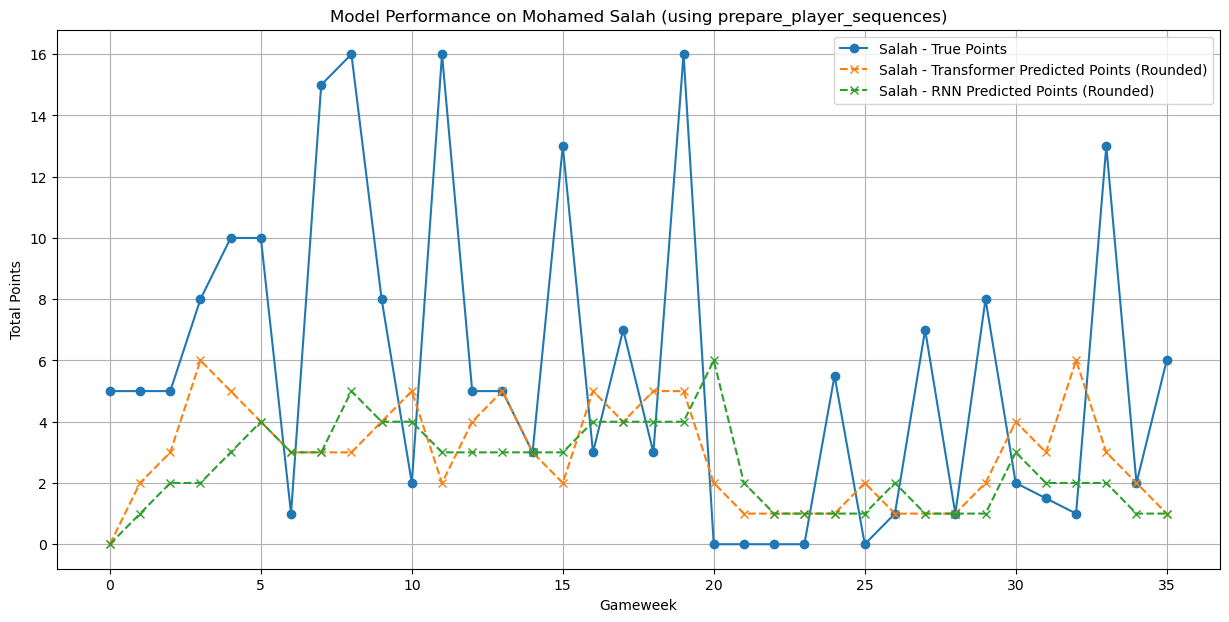

In [38]:
salah_predictions_transformer = []
salah_predictions_rnn = []

with torch.no_grad():
    for i in range(salah_sequences_scaled.shape[0]):
        seq_input = salah_sequences_tensor[i].unsqueeze(0)
        mask_input = salah_masks_tensor[i].unsqueeze(0)
        pred_transformer = best_model_final(seq_input, mask_input) 
        pred_rnn = best_rnn_model_final(seq_input, mask_input) 


        salah_predictions_transformer.append(np.expm1(pred_transformer.item()))
        salah_predictions_rnn.append(np.expm1(pred_rnn.item()))

salah_predictions_transformer_rounded = np.round(salah_predictions_transformer)
salah_predictions_rnn_rounded = np.round(salah_predictions_rnn)



plt.figure(figsize=(15, 7))
plt.plot(np.expm1(salah_targets), label='Salah - True Points', marker='o')
plt.plot(salah_predictions_transformer_rounded, label='Salah - Transformer Predicted Points (Rounded)', marker='x', linestyle='--')
plt.plot(salah_predictions_rnn_rounded, label='Salah - RNN Predicted Points (Rounded)', marker='x', linestyle='--')
plt.xlabel("Gameweek")
plt.ylabel("Total Points")
plt.title(f"Model Performance on Mohamed Salah (using prepare_player_sequences)")
plt.legend()
plt.grid(True)
plt.show()